### Available Methods
- Combinatorial
    - Exhaustive if $p \leq 10$.
    - Random Walk.
        - Randomly try matrices.
        - Transition to close matrix.
    - Metropolis Hastings.
- Continuous Optimization.
    - Gradient Descent.
    - LASSO-DAG
    - NO TEARS for VAR(1) models.
- Greedy
    - Forward
        - OMP
        - OLS
        - LiNGAM
    - Backward
        - OMP
        - OLS
        - LiNGAM
    - Backward - Violations First
        - OMP
        - OLS
        - LiNGAM

In [1]:
from importlib import reload  # Python 3.4+

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from timeit import default_timer as timer
import itertools

from sklearn.linear_model import LassoLars, LassoLarsIC

In [2]:
reload(h);
reload(m);

[[ 0.72134561  0.          0.          0.        ]
 [ 0.          0.55092266  0.          0.        ]
 [-0.6993925   0.51984106  0.64251941  0.        ]
 [ 0.          0.          0.          0.50649952]]


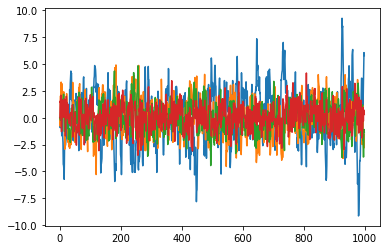

In [3]:
T, p = 1000, 4
m.T, m.p = T, p

W = h.generate_A(p, 2, tril = True, high = 0.75)
for i in range(p):
    W[i][i] = np.random.uniform(0.5, 0.75)
    
X = h.generate_var_2(T, p, W, np.identity(p))

print(W)
plt.plot(X);

In [4]:
m.p = p
m.rw_1(X[:-1], X[1:], np.identity(p), 100)
m.rw_2(X[:-1], X[1:], np.identity(p), 100)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1381.31it/s]


(array([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]]),
 array([[ 0.72097759,  0.        ,  0.        ,  0.        ],
        [-0.0173444 ,  0.55613907,  0.        ,  0.        ],
        [-0.68265368,  0.52566326,  0.63787526,  0.        ],
        [ 0.01648208, -0.05016201, -0.00821185,  0.51612498]]),
 3.9359469695229423)

### Exhaustive

In [5]:
def exh(X, Y, is_sem = False):
    perms = itertools.permutations(np.identity(p))
    total = np.math.factorial(p)

    Psi = X.T.dot(X)
    K   = X.T.dot(Y)

    P_best = np.identity(p)
    W_best = k_ols_W(Psi, K, P_best, is_sem = is_sem)
    L_best = loss(W_best, X, Y)

    for perm in tqdm(perms, total = total):
        perm = np.array(perm)
        W = k_ols_W(Psi, K, perm, is_sem = is_sem)
        L = loss(W, X, Y)

        if L < L_best:
            P_best, W_best, L_best = perm, W, L
            
    return P_best, W_best, L_best

In [6]:
P_best, W_best, L_best = exh(X[:-1], X[1:], is_sem = True)
print(f"Exhaustively best P:\n{P_best},\n\nExhaustively best W:\n{np.round(W_best, 2)},\n\nLikelihood: {round(L_best, 2)}.")

NameError: name 'k_ols_W' is not defined

In [7]:
m.p = 4
P_best, W_best, L_best = m.exh(X[:-1], X[1:], is_sem = True)
print(f"Exhaustively best P:\n{P_best},\n\nExhaustively best W:\n{np.round(W_best, 2)},\n\nLikelihood: {round(L_best, 2)}.")

100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1536.84it/s]

Exhaustively best P:
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]],

Exhaustively best W:
[[ 0.    0.    0.    0.  ]
 [-0.56  0.    0.    0.  ]
 [-0.96  0.81  0.    0.  ]
 [-0.02 -0.05 -0.02  0.  ]],

Likelihood: 7.88.


### RandomWalk

In [8]:
def rw(X, Y, max_it, P, verbose = False, total_time = 1e10, is_sem = False):
    
    Psi = X.T.dot(X)
    K = X.T.dot(Y)
    
    n, p = np.shape(X)

    start = timer()
    
    # smallest likelihood
    min_likelihood = 0 # loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
    
    # initial value
    likelihood_P = loss(k_ols_W(Psi, K, P, is_sem = is_sem), X, Y) - min_likelihood

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    for i in tqdm(range(max_it)):   
        # check if time has passed
        if timer() - start > total_time: 
            break
            
        # sample next P
        P_prime = sample_next_P_2(P)

        W = k_ols_W(Psi, K, P_prime, is_sem = is_sem)
        L = loss(W, X, Y)

        if L < L_best:
            P_best, W_best, L_best = P_prime, W, L

    return P_best, W_best, L_best

In [9]:
P_best, W_best, L_best = rw(X[:-1], X[1:], 100, np.identity(p))

NameError: name 'loss' is not defined

### MCMC

In [10]:
def sample_next_P(P):  
    # get copy
    P_return = P.copy()

    # get the two rows to swap
    i, j = np.random.choice(p, 2, replace = False)

    # swap row i and row j
    P_return[[i, j]] = P_return[[j, i]]

    # return new sample
    return P_return

def sample_next_P_2(P):  
    # get copy
    return np.random.permutation(np.identity(p))

def loss(W, X, Y):
    return 1 / len(X) * np.linalg.norm(Y - X @ W, 'f') ** 2

def expected_MSE_X(W):
    return np.linalg.inv(np.identity(p) - W).T @ np.linalg.inv(np.identity(p) - W)

def true_loss(W_est, W_true):
    return np.trace((W_est - np.identity(p)).T @ expected_MSE_X(W_true) @ (W_est- np.identity(p)))

def get_likelihood(P, X, Y):
    # get optimal A for this permutation
    W_opt = k_ols_W(Psi, K, P)

    # get loss    
    return loss(k_ols_W(Psi, K, P), X, Y)

def k_ols_W(Psi, K, P, is_sem = True):
    # translate X
    psi = P @ Psi @ P.T
    k = P @ K @ P.T

    W_hat = np.zeros((p, p))

    # get parameters
    if is_sem:
        for i in range(1, p):
            psi_F = psi[np.array(range(i))[:, None], np.array(range(i))[None, :]]   
            W_hat[np.array(range(i))[:, None], i] = np.linalg.inv(psi_F) @ k[np.array(range(i))[:, None], i]
    else: 
        for i in range(p):
            psi_F = psi[np.array(range(i+1))[:, None], np.array(range(i+1))[None, :]]   
            W_hat[np.array(range(i+1))[:, None], i] = np.linalg.inv(psi_F) @ k[np.array(range(i+1))[:, None], i]

    return P.T @ W_hat @ P

def acc_prob_reg(L, L_new):
    return min(L / L_new, 1)

def acc_prob_trans(L, L_new, L_ols):
    return min((L - L_ols) / (L_new - L_ols), 1)

def acc_prob_pow(L, L_new, k):
    return min((L / L_new) ** k, 1)

def acc_prob_trans_pow(L, L_new, k, L_ols):
    return min(((L - L_ols) / (L_new - L_ols)) ** k, 1)

def acc_prob_greed(L, L_new):
    return L_new < L

def mcmc(X, Y, max_it, P, verbose = False, factor = 1.0, total_time = 1e10, is_sem = False):
    
    Psi = X.T.dot(X)
    K = X.T.dot(Y)
    
    n, p = np.shape(X)

    start = timer()
    
    # smallest likelihood
    min_likelihood = 0 # loss(np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:], X)
    
    # initial value
    likelihood_P = loss(k_ols_W(Psi, K, P, is_sem = is_sem), X, Y) - min_likelihood

    # current bests
    P_best, L_best = P.copy(), likelihood_P.copy()
    
    # results
    results_likelihood = [L_best]
    results_l_iter = []
    results_l_transition = []
    results_l_next = []
    num_missed_edges = []

    # transitions
    transitions = 0
    
    for i in tqdm(range(max_it)):   
        # check if time has passed
        if timer() - start > total_time: 
            break
            
        # sample next P
        P_prime = sample_next_P(P)
    
        # compute acceptance probability
        likelihood_P_prime = loss(k_ols_W(Psi, K, P_prime, is_sem = is_sem), X, Y)
        alpha = acc_prob_greed(likelihood_P, likelihood_P_prime)
        
        # print results
        if verbose:
            print(f"Iteration {i+1}.\n")
            print(f"Old P:\n{P}\nLikelihood: {round(likelihood_P, 2)}\n\nNew P:\n{P_prime}\nLikelihood: {round(likelihood_P_prime, 2)}.")
            print(f"\nAcceptance probability: {round(alpha, 3)}.")
    
        # prepare for next iteration
        if np.random.rand() <= alpha:
            transitions += 1
            P, likelihood_P = P_prime, likelihood_P_prime
            results_l_transition.append(likelihood_P_prime)
            # save best
            if likelihood_P < L_best:
                L_best = likelihood_P
                P_best = P
        
        # results
        results_l_next.append(likelihood_P_prime)
        results_likelihood.append(L_best)
        results_l_iter.append(likelihood_P)
        # check_triu = np.triu(P_best @ P_true.T @ B_true @ P_true @ P_best.T)
        # num_missed_edges.append(len(check_triu[check_triu != 0]))
    
    if verbose:
        print(transitions)
        print(f"Best permutation:\n{P_best}\n\nLikelihood: {round(L_best, 2)}.")

    W_best = k_ols_W(Psi, K, P_best, is_sem)
    return P_best, W_best, [results_l_iter, results_likelihood, results_l_transition, results_l_next, num_missed_edges]

In [11]:
P_mcmc, W_mcmc, r = mcmc(X[:-1], X[1:], int(1e3), np.identity(p), is_sem = True);
print(W_mcmc)
m.mcmc(X[:-1], X[1:], int(1e3), np.identity(p), is_sem = True, v = 0);
print(f"Loss: {round(loss(W_mcmc, x, y), 3)}.")

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1478.84it/s]

[[ 0.          0.          0.          0.        ]
 [-0.56133987  0.          0.          0.        ]
 [-0.9562956   0.81460035  0.          0.        ]
 [-0.01920982 -0.05412105 -0.02476012  0.        ]]


AttributeError: module 'helper.methods' has no attribute 'mcmc'

### LASSO DAG

In [12]:
def lasso_lars_W(X, alpha):
    """Performs LASSO with Lars on X with regularization value alpha"""
    
    # get regressor and variables
    y = X[1:]
    x = X[:-1]

    # initialize W_hat
    W_hat = np.array([])

    # Get our regularization method
    reg = LassoLars(alpha=alpha, normalize=False)
    
    # get parameters
    for i in range(p):
        est = reg.fit(x, y[:, i])
        W_hat = np.append(W_hat, est.coef_)

    # return W_hat after reshape
    return W_hat.reshape((p, p)).T

In [13]:
def lingnam_lasso_lars(X, step_size = 0.1):
    """Incrementally increase penalty by step_size until we have aa DAG"""
    
    # initial L1 penalty
    alpha = 0.0
    
    # get W_hat with 0 penalty -> OLS
    W_ols = lasso_lars_W(X, alpha)
    W_hat = W_ols.copy()
    
    # while we do not have a dag
    while not h.is_dag(W_hat):
        # increase alpha and do lasso with increased alpha
        alpha += step_size
        W_hat = lasso_lars_W(X, alpha)

    # return W_hat and print smallest alpha
    print(f"Smallest alpha for DAG: {round(alpha, 5)}.")
    return W_hat

In [14]:
# lasso_lars_W(X, 0.5)
lingnam_lasso_lars(X, step_size = 0.05)

Smallest alpha for DAG: 0.1.


array([[ 7.21449576e-01, -3.30601856e-04,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  5.35235842e-01,  0.00000000e+00,
         0.00000000e+00],
       [-6.31845684e-01,  4.77543118e-01,  5.78278195e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.38878314e-01]])

### NOTEARS VAR

In [15]:
m._notears_2(X, lambda1 = 0.3)

(array([[ 0.71384204,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.48917495,  0.        ,  0.        ],
        [-0.51819903,  0.37725325,  0.45873455,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.2890866 ]]),
 0.0)

### DAG-OMP

In [16]:
print(np.shape(X))

x = np.vstack((X[:-1], X[-1]))
print(np.shape(x))

(1000, 4)
(1000, 4)


In [17]:
m._OLS(X)



array([[ 0.72097759,  0.00227582,  0.00845491,  0.00111112],
       [-0.0173444 ,  0.55785623,  0.00661003,  0.02333916],
       [-0.68265368,  0.52652703,  0.64096446, -0.00576345],
       [ 0.01648208, -0.05004934, -0.00779165,  0.51648298]])

In [18]:
m.p = p
m._K_OMP(X[:-1], X[1:])

(array([[ 7.26260755e-01,  2.27581816e-03,  0.00000000e+00,
         -6.23651695e-03],
        [ 0.00000000e+00,  5.57856229e-01,  0.00000000e+00,
          0.00000000e+00],
        [-6.87933480e-01,  5.26527033e-01,  6.38043459e-01,
          6.93128727e-04],
        [ 0.00000000e+00, -5.00493432e-02,  0.00000000e+00,
          5.15992557e-01]]),
 3932.715944367014)

### OLS-DAG

In [19]:
def expected_cost_var(W_true, W_est):
    
    # covariance matrix
    covariance_matrix = np.identity(p) + np.matmul((W_true - W_est).T, np.matmul(covariance_X.T, (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

In [20]:
T, p = 250, 10
m.T, m.p = T, p

W = h.generate_A_2(p, 5, tril = True, high = 0.75)
W = np.random.permutation(W)
for i in range(p):
    W[i][i] = np.random.uniform(0.25, 0.50)

print(W)

covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))

X = h.generate_var_2(T, p, W, np.identity(p))
iters = 1000
datasets = [X]

# for each dataset
for dataset in datasets:
    # for each method:
    T, p = np.shape(dataset)
    
    # 1: Exhaustive:
    if p < 10:
        W_exh = m.exh(X[:-1], X[1:])
        
    # 2.1: Random Walk 1, need regularizing
    W_rw_1 = con_LASSO(X, m.rw_1(X[:-1], X[1:], np.identity(p), iters)[1] != 0)
    _, _, _, _, shd_rw_1, mse_rw_1, _ = h.score(X, W_rw_1, W, printing = False)
    error_rw_1 = expected_cost_var(W, W_rw_1)
    print("Random Walk: Close permutations.")
    print(f"SHD: {shd_rw_1}, Empirial Risk: {round(mse_rw_1, 3)}, True Risk: {round(error_rw_1, 3)}.")
    
    # 2.2: Random Walk 2
    W_rw_2 = con_LASSO(X, m.rw_2(X[:-1], X[1:], np.identity(p), iters)[1] != 0)
    _, _, _, _, shd_rw_2, mse_rw_2, _ = h.score(X, W_rw_2, W, printing = False)
    error_rw_2 = expected_cost_var(W, con_OLS(X, W_rw_2 != 0))
    print("Random Walk: Any permutations.")
    print(f"SHD: {shd_rw_2}, Empirial Risk: {round(mse_rw_2, 3)}, True Risk: {round(error_rw_2, 3)}.")
    
    # 3.1: MCMC 1
    W_mcmc_1 = con_LASSO(X, m.mcmc_1(X[:-1], X[1:], iters, np.identity(p))[1] != 0)
    _, _, _, _, shd_mcmc_1, mse_mcmc_1, _ = h.score(X, W_mcmc_1, W, printing = False)
    error_mcmc_1 = expected_cost_var(W, con_OLS(X, W_mcmc_1 != 0))
    print("MCMC: Regular.")
    print(f"SHD: {shd_mcmc_1}, Empirial Risk: {round(mse_mcmc_1, 3)}, True Risk: {round(error_mcmc_1, 3)}.")
    
    # 3.2: MCMC 2
    W_mcmc_2 = con_LASSO(X, m.mcmc_2(X[:-1], X[1:], iters, np.identity(p))[1] != 0)
    _, _, _, _, shd_mcmc_2, mse_mcmc_2, _ = h.score(X, W_mcmc_2, W, printing = False)
    error_mcmc_2 = expected_cost_var(W, con_OLS(X, W_mcmc_2 != 0))
    print("MCMC: Translated.")
    print(f"SHD: {shd_mcmc_2}, Empirial Risk: {round(mse_mcmc_2, 3)}, True Risk: {round(error_mcmc_2, 3)}.")
    
    # 3.3: MCMC 3
    W_mcmc_3 = con_LASSO(X, m.mcmc_3(X[:-1], X[1:], iters, np.identity(p))[1] != 0)
    _, _, _, _, shd_mcmc_3, mse_mcmc_3, _ = h.score(X, W_mcmc_3, W, printing = False)
    error_mcmc_3 = expected_cost_var(W, con_OLS(X, W_mcmc_3 != 0))
    print("MCMC: Squared.")
    print(f"SHD: {shd_mcmc_3}, Empirial Risk: {round(mse_mcmc_3, 3)}, True Risk: {round(error_mcmc_3, 3)}.")
    
    # 3.4: MCMC 4
    W_mcmc_4 = con_LASSO(X, m.mcmc_4(X[:-1], X[1:], iters, np.identity(p))[1] != 0)
    _, _, _, _, shd_mcmc_4, mse_mcmc_4, _ = h.score(X, W_mcmc_4, W, printing = False)
    error_mcmc_4 = expected_cost_var(W, con_OLS(X, W_mcmc_4 != 0))
    print("MCMC: Greedy.")
    print(f"SHD: {shd_mcmc_4}, Empirial Risk: {round(mse_mcmc_4, 3)}, True Risk: {round(error_mcmc_4, 3)}.")
    
    # 4: NO TEARS, NEED TO REGULARIZE using bootstrap.
    W_notears, _ = m.notears_2(X, lambda1 = 0.1)
    _, _, _, _, shd_notears, mse_notears, _ = h.score(X, W_notears, W, printing = False)
    error_notears = expected_cost_var(W, con_OLS(X, W_notears != 0))
    print("NO TEARS.")
    print(f"SHD: {shd_notears}, Empirial Risk: {round(mse_notears, 3)}, True Risk: {round(error_notears, 3)}.")
    
    # 5: LASSO-DAG, NEED TO REGULARIZE using bootstrap.
    W_lassodag, _ = m._LASSO_LINGNAM(X, step_size = 1)
    _, _, _, _, shd_lassodag, mse_lassodag, _ = h.score(X, W_lassodag, W, printing = False)
    error_lassodag = expected_cost_var(W, con_OLS(X, W_lassodag != 0))
    print("DAG-LASSO.")
    print(f"SHD: {shd_lassodag}, Empirial Risk: {round(mse_lassodag, 3)}, True Risk: {round(error_lassodag, 3)}.")
    
    # 6: DAG-OMP, NEED TO REGULARIZE using cross-validation.
    W_omp, _ = m._K_OMP(X[:-1], X[1:], F = [], normalize = True)
    _, _, _, _, shd_omp, mse_omp, _ = h.score(X, W_omp, W, printing = False)
    error_omp = expected_cost_var(W, con_OLS(X, W_omp != 0))
    print("DAG-OMP.")
    print(f"SHD: {shd_omp}, Empirial Risk: {round(mse_omp, 3)}, True Risk: {round(error_omp, 3)}.")
    
    # 7: DAG-LASSO, NEED TO REGULARIZE using bootstrap.
    W_olsdag, _ = m._OLS_LINGNAM(X)  
    _, _, _, _, shd_olsdag, mse_olsdag, _ = h.score(X, W_olsdag, W, printing = False)
    error_olsdag = expected_cost_var(W, con_OLS(X, W_olsdag != 0))
    print("DAG-OLS.")
    print(f"SHD: {shd_olsdag}, Empirial Risk: {round(mse_olsdag, 3)}, True Risk: {round(error_olsdag, 3)}.")

90
[[ 0.2804218   0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.46044442  0.          0.          0.          0.
  -0.61596629  0.          0.          0.        ]
 [ 0.          0.          0.47312655  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.37689109  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.43711933  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.3438706
   0.          0.         -0.50529041  0.        ]
 [-0.57439982  0.          0.          0.          0.          0.
   0.44128447  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.49741363  0.          0.        ]
 [ 0.          0.          0.          0.          0. 

NameError: name 'con_LASSO' is not defined

In [21]:
help(m._LASSO_LINGNAM)

Help on function _LASSO_LINGNAM in module helper.methods:

_LASSO_LINGNAM(X, step_size=0.01, normalize=False)
    Incrementally increase penalty by step_size until we have a DAG



In [22]:
def con_OLS(X, B):
    W = np.zeros((p, p))
    for i in range(p):
        X_F = X[:, B[:, i]]
        W[B[:, i], i] = np.linalg.inv(X_F[:-1].T @ X_F[:-1]) @ X_F[:-1].T @ X[1:, i]
        
    return W

In [23]:
def con_LASSO(X, B, criterion = 'aic', alpha = 0.01):
    
    T, p = np.shape(X)
    
    X_large = np.kron(np.eye(p, dtype=float), X[:-1])
    y_large = X[1:].T.reshape((T - 1) * p, )
    
    for i in range(p):
        for j in range(p):
            if B[i][j] == 0:
                to_remove = j * p + i
                X_large[:, to_remove] = np.zeros((T - 1) * p)
                
    
    clf = LassoLarsIC(criterion = criterion, fit_intercept = False, normalize = False, )
    clf.fit(X_large, y_large)
    
    return con_OLS(X, clf.coef_.reshape(p, p).T != 0)

In [24]:
W_omp, _ = m._K_OMP(X[:-1], X[1:], normalize = True, F = [])
h.score(X, con_LASSO(X, W_omp != 0, criterion = 'aic'), W)
print()
h.score(X, con_LASSO(X, W_omp != 0, criterion = 'bic'), W)

True Positive Rate: 1.0.
True Negative Rate: 0.871.
False Prediction Rate: 0.423
Accuracy: 0.89.
R-Squared: 0.494
Mean Squared Error: 9.982

True Positive Rate: 1.0.
True Negative Rate: 0.988.
False Prediction Rate: 0.062
Accuracy: 0.99.
R-Squared: 0.485
Mean Squared Error: 10.146


(1.0,
 0.9882352941176471,
 0.0625,
 0.99,
 1,
 10.146456221358456,
 0.4853923403168792)

[0.68588134 0.7146522  0.70981584 0.77273101 0.76857721 0.68448052
 0.7930804  0.71089997 0.79194788 0.68990987]
[[ 0.8  0.5  0.   0.5  0.   0.5  0.5  0.   0.   0. ]
 [ 0.   0.8  0.   0.5  0.   0.   0.5  0.   0.   0. ]
 [-0.5  0.   0.7  0.   0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.8  0.   0.  -0.5  0.   0.   0. ]
 [ 0.  -0.5  0.  -0.5  0.7 -0.5  0.5  0.  -0.5 -0.5]
 [ 0.   0.   0.   0.   0.   0.8  0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.7  0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.   0.5  0.7  0.   0. ]
 [ 0.  -0.5  0.   0.   0.   0.  -0.5  0.   0.7  0. ]
 [-0.5 -0.5  0.   0.   0.  -0.5  0.5  0.5  0.   0.7]]


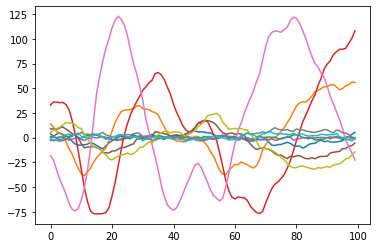

In [25]:
T, p = 100, 10
reload(m)
m.T, m.p = T, p

W = np.zeros((p, p))
W = h.generate_A(p, 25, tril = True, low = 0.5, high = 0.5)

for i in range(p):
    W[i][i] = np.random.uniform(0.6, 0.8)


covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))
print(np.linalg.eig(W)[0])

P = np.random.permutation(np.identity(p))
W = P @ W @ P.T
print(np.round(W, 1))
X = h.generate_var_2(2 * T, p, W, np.identity(p))[T:]
plt.plot(X)
covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))

In [26]:
# 1: Exhaustive:
# if p < 10:
#     _, W_exh, _ = m.exh(X[:-1], X[1:])
#     _, _, _, _, shd_exh, mse_exh, _ = h.score(X, W_exh, W, printing = False)
#     error_exh = expected_cost_var(W, W_exh)
#     print("Exhaustive.")
#     print(f"SHD: {shd_exh}, Empirial Risk: {round(mse_exh, 3)}, True Risk: {round(error_exh, 3)}.")

iters = 1000
# # 2.1: Random Walk 1, need regularizing
W_rw_1 = m.rw_1(X[:-1], X[1:], np.identity(p), iters)[1]
print(np.round(W_rw_1, 2))
_, _, _, _, shd_rw_1, mse_rw_1, _ = h.score(X, W_rw_1, W, printing = False)
error_rw_1 = expected_cost_var(W, W_rw_1)
print("Random Walk: Close permutations.")
print(f"SHD: {shd_rw_1}, Empirial Risk: {round(mse_rw_1, 3)}, True Risk: {round(error_rw_1, 3)}.")

# 2.2: Random Walk 2
W_rw_2 = m.rw_2(X[:-1], X[1:], np.identity(p), iters)[1]
print(np.round(W_rw_2, 1))
_, _, _, _, shd_rw_2, mse_rw_2, _ = h.score(X, W_rw_2, W, printing = False)
error_rw_2 = expected_cost_var(W, con_OLS(X, W_rw_2 != 0))
print("Random Walk: Any permutations.")
print(f"SHD: {shd_rw_2}, Empirial Risk: {round(mse_rw_2, 3)}, True Risk: {round(error_rw_2, 3)}.")

  3%|██▍                                                                            | 31/1000 [00:00<00:03, 298.13it/s]

[[ 0.95  0.48  0.03  0.48  0.01  0.5   0.56 -0.01 -0.02  0.11]
 [ 0.    0.8   0.    0.52  0.    0.    0.49 -0.01  0.    0.  ]
 [ 0.    0.05  0.71  0.11 -0.02  0.    0.08  0.   -0.04  0.16]
 [ 0.    0.    0.    0.78  0.    0.   -0.5   0.    0.    0.  ]
 [ 0.   -0.31  0.   -0.42  0.64  0.    0.51 -0.09 -0.46 -0.48]
 [ 0.    0.03 -0.01  0.03  0.    0.82 -0.09  0.01  0.54 -0.08]
 [ 0.    0.    0.    0.    0.    0.    0.69  0.    0.    0.  ]
 [ 0.    0.    0.   -0.49  0.    0.    0.44  0.7   0.    0.  ]
 [ 0.   -0.51  0.   -0.    0.    0.   -0.47 -0.02  0.66  0.02]
 [ 0.   -0.53  0.    0.02  0.    0.    0.6   0.5   0.    0.72]]
Random Walk: Close permutations.
SHD: 30, Empirial Risk: 11.846, True Risk: 13.093.


 97%|███████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:03<00:00, 323.01it/s]


KeyboardInterrupt: 

Random Walk: Close permutations.
SHD: 40, Empirial Risk: 12.528, True Risk: 13.457.

Random Walk: Any permutations.
SHD: 17, Empirial Risk: 11.816, True Risk: 12.909.

In [ ]:
import numpy as np
import itertools
from tqdm import tqdm
def get_permutations(W):
    """@params: Weighted Adjacency Matrix W as numpy array"""
    # tracks the total number of permutations
    total = 0
    perms = []
    
    # iterate over all permutations of the identity matrix
    for perm in tqdm(itertools.permutations(np.identity(np.shape(W)[0]))):
        # convert to numpy array
        P = np.array(perm)
        
        # check if we have an upper triangular matrix
        if np.allclose(P.T @ W @ P, np.triu(P.T @ W @ P)):
            total += 1
            perms.append(P)
            
    # return the number of suitable permutations
    return perms, total


P_imp, total_P = get_permutations(W)

In [ ]:
Psi = X[:-1].T.dot(X[:-1])
K   = X[:-1].T.dot(X[1:])

P_best = np.identity(p)
W_best = k_ols_W(Psi, K, P_best, is_sem = False)
L_best = loss(W_best, X[:-1], X[1:])

for perm in P_imp:
    perm = np.array(perm.T)
    W = k_ols_W(Psi, K, perm, is_sem = False)
    L = loss(W, X[:-1], X[1:])

    if L < L_best:
        P_best, W_best, L_best = perm, W, L
            
print(L_best)

In [ ]:
plt.plot(X);

In [ ]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
## Plot series
fig = plt.figure(figsize = (5.5, 2.5))
fig.patch.set_alpha(0)
plt.xlabel(r"Time step $t$")
plt.ylabel(r"Value")
plots = plt.plot(X); 
# plt.legend(plots, [r"$X_1$", r"$X_2$", r"$X_3$"], loc = 1);
plt.savefig('figure random walk example.pgf')

In [191]:
help(h.save_data)
h.save_data(X, W, "RW_ex", "this data was used in the random walk example.")

Help on function save_data in module helper.helper:

save_data(X, W, misc, expl, directory='')
    Saves dataset X, matrix W

Dataset saved with name X_s55_n100_T10_RW_ex_0.


C:\Users\s165048\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [192]:
def con_LASSO(X, B, criterion = 'aic', alpha = 0.01):
    
    T, p = np.shape(X)
    
    X_large = np.kron(np.eye(p, dtype=float), X[:-1])
    y_large = X[1:].T.reshape((T - 1) * p, )
    
    for i in range(p):
        for j in range(p):
            if B[i][j] == 0:
                to_remove = j * p + i
                X_large[:, to_remove] = np.zeros((T - 1) * p)
                
    
    clf = LassoLarsIC(criterion = criterion, fit_intercept = False, normalize = False, )
    clf.fit(X_large, y_large)
    
    return con_OLS(X, clf.coef_.reshape(p, p).T != 0)

In [196]:
con_LASSO(X, W != 0, criterion = 'bic')

array([[ 0.78247574,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.21862479,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.92530615,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.74221889,
         0.        ,  0.        ,  0.24528817,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.90814394,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.17846587,
         0.        ,  0.96614017,  0.        

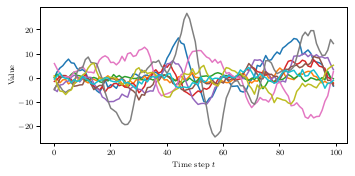

In [198]:
## Plot series
fig = plt.figure(figsize = (5.5, 2.5))
fig.patch.set_alpha(0)
plt.xlabel(r"Time step $t$")
plt.ylabel(r"Value")
plots = plt.plot(X); 
# plt.legend(plots, [r"$X_1$", r"$X_2$", r"$X_3$"], loc = 1);
plt.savefig('figure random walk example_v2.pgf', bbox_inches = 'tight')

In [27]:
def gen_var(W, T):
    p = np.shape(W)[0]
    noises = np.zeros((2 * T, p))
    
    X = np.zeros((2 * T, p))
    X[0] = np.random.multivariate_normal(np.zeros(p), np.identity(p))
    
    noises[1:] = np.random.multivariate_normal(np.zeros(p), np.identity(p), 2 * T - 1)
    
    for t in range(1, 2 * T):
        X[t] = X[t - 1] @ W + noises[t]
        
    return X[T:]

def gen_var_noises(W, T, noises):
    p = np.shape(W)[0]
    
    X = np.zeros((T, p))
    X[0] = noises[0]
    
    for t in range(1, T):
        X[t] = X[t - 1] @ W + noises[t]

    return X

def gen_var_noises_stat(W, T, noises):
    p = np.shape(W)[0]
    
    X = np.zeros((T, p))
    X[0] = noises[0]
    
    for t in range(1, T):
        X[t] = X[t - 1] @ W + noises[t]

    return X[T // 2:]

[[ 0.6    0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.6    0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.6    0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.722  0.     0.6    0.     0.     0.     0.     0.     0.   ]
 [-0.723  0.623  0.     0.     0.6    0.     0.     0.     0.     0.   ]
 [ 0.     0.757  0.     0.     0.     0.6    0.     0.     0.     0.   ]
 [ 0.     0.     0.55   0.     0.     0.     0.6    0.     0.     0.   ]
 [ 0.462  0.     0.517 -0.42   0.     0.     0.     0.6    0.     0.   ]
 [-0.769  0.     0.     0.736  0.     0.    -0.559  0.651  0.6    0.   ]
 [-0.763  0.    -0.411  0.772  0.     0.     0.     0.     0.     0.6  ]]


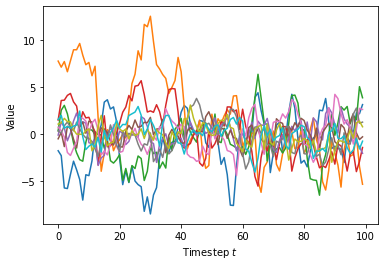

In [28]:
np.random.seed(seed = 12345)

# Number of dimensions, number of edges, number of samples
T, p, s = 100, 10, 15
N = int(p * (p + 1) / 2)

### Coefficient matrix
W_true = h.generate_A(p, s, tril = True, low = 0.4, high = 0.80)

for i in range(p):
    W_true[i][i] = 0.6 # np.abs(A_true[i][i])

s = len(W_true.flatten().nonzero()[0])

## Generate series
X = gen_var(W_true, 2 * T)[T:]
print(np.round(W_true, 3))
## Plot series
plt.xlabel(r"Timestep $t$")
plt.ylabel(r"Value")
plots = plt.plot(X); 

# ## Plot series
# fig = plt.figure(figsize = (5.5, 3))
# fig.patch.set_alpha(0)
# plt.xlabel(r"Timestep $t$")
# plt.ylabel(r"Value")
# plots = plt.plot(X); 
# plt.legend(plots, [r"$X_1$", r"$X_2$", r"$X_3$"], loc = 1);
# plt.savefig('figure exhaustive example.pgf')

In [32]:
# 3.4: MCMC 4
W_mcmc_4 = m.mcmc_4(X[:-1], X[1:], iters, np.identity(p))[1]
_, _, _, _, shd_mcmc_4, mse_mcmc_4, _ = h.score(X, W_mcmc_4, W, printing = False)
# error_mcmc_4 = expected_cost_var(W_true, con_OLS(X, W_mcmc_4 != 0))
print("MCMC: Greedy.")
print(f"SHD: {shd_mcmc_4}, Empirial Risk: {round(mse_mcmc_4, 3)}") # True Risk: {round(error_mcmc_4, 3)}.")

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.93it/s]

MCMC: Greedy.
SHD: 40, Empirial Risk: 9.736


In [35]:
# get order using DAG-LASSO.
def get_evolution_lasso(X, step_size = 0.2):
    """Returns the evolution paths for lasso with X as data"""
    
    # solution paths will be saved here
    results, alphas, coefs_zero = [], [], []
    
    # initial L1 penalty
    alpha = 0.0
    
    # get W_hat with 0 penalty -> OLS
    W_ols = lasso_lars_W(X, alpha)
    W_hat = W_ols.copy()
    
    # get number of non-zero coefficients for this value
    non_zero_coefs = W_hat.copy().flatten()
    non_zero_coefs[non_zero_coefs != 0] = 1
    
    # append the values of this iteration
    coefs_zero.append(non_zero_coefs)
    results.append(W_hat.flatten())
    alphas.append(alpha)
    
    # for simplicity I assume we have no DAG for OLS
    # else this approach is not meaningful anyway
    dag_yet, dag_alpha = False, 0
    
    # while we have non-zero coefficients
    while len(W_hat[W_hat != 0]) > 0:
        
        # perform lasso with increased step size
        alpha += step_size
        W_hat = lasso_lars_W(X, alpha)
        
        # get new nonzero coefficients
        non_zero_coefs = W_hat.copy().flatten()
        non_zero_coefs[non_zero_coefs != 0] = 1
        
        # check if we have found smallest lambda that makes a DAG        
        if h.is_dag(W_hat) and not dag_yet:
            dag_alpha = alpha
            dag_yet = True
        
        # append results
        results.append(W_hat.flatten())
        coefs_zero.append(non_zero_coefs)    
        alphas.append(alpha)
    
    # for nicer plot, last part of all zero plotted
    alpha *= 1.2
    W_hat = lasso_lars_W(X, alpha)
    
    # number of non-zero coefficents should be all
    non_zero_coefs = W_hat.copy().flatten()
    non_zero_coefs[non_zero_coefs != 0] = 1
    
    # append last results
    results.append(W_hat.flatten())
    coefs_zero.append(non_zero_coefs)
    alphas.append(alpha)
        
    # return results
    return results, alphas, coefs_zero, dag_alpha

get_evolution_lasso(X)

([array([ 6.32718621e-01,  6.78661470e-02,  5.61008247e-02, -4.60822032e-02,
          1.29216104e-01, -9.40427315e-02,  4.96466056e-02,  1.73824827e-02,
          3.14184945e-02,  9.33922329e-02, -5.35502591e-02,  5.99354183e-01,
          2.68852959e-02,  2.50843997e-02, -2.54335563e-02, -2.71288440e-02,
          1.07435160e-02, -5.88151150e-02,  7.35489223e-02,  4.56270951e-03,
          2.30973726e-02,  1.42641952e-02,  5.22352552e-01, -5.28560023e-02,
          1.21533805e-02, -6.48013296e-02, -1.26733926e-02,  4.38667091e-02,
          6.60269406e-02, -3.31871251e-02,  9.41742680e-02,  8.27983223e-01,
          2.34557930e-02,  4.92085745e-01,  9.50848361e-02, -3.26282640e-02,
          3.72001503e-02,  1.22007663e-01, -7.30394281e-02,  7.59769949e-02,
         -7.91724808e-01,  5.57248657e-01, -4.74720322e-02, -6.01031814e-02,
          5.64926404e-01, -7.56545548e-03, -5.15248137e-02,  1.52221627e-01,
         -4.81833505e-02,  1.58997066e-01,  1.04849412e-01,  8.38679168e-01,

In [36]:
# get results
results, alphas, coefs_zero, dag_alpha = get_evolution_lasso(X, step_size = 0.01)

# get points for which each coefficient is zero
zero_points = []

for i in range(len(coefs_zero[0])):
    zero_points.append(alphas[np.argmin(np.array(coefs_zero)[:,i])])

# get order of coefficients based on "strength"
order = np.argsort(zero_points)

# convert to numpy array for column accessibility
results = np.array(results)

# remove this, as we have a special color for this one
zero_points.remove(dag_alpha)

print(np.shape(results))
print(len(results[0]))

(1849, 100)
100


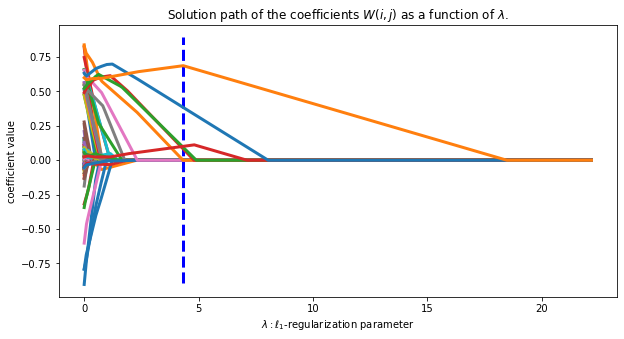

KeyboardInterrupt: 

In [42]:
# Figure with title and labels
plt.figure(figsize=(10, 5))
plt.title(r"Solution path of the coefficients $W(i, j)$ as a function of $\lambda$.")
plt.xlabel(r'$\lambda: \ell_1$-regularization parameter')
plt.ylabel('coefficient value')
labels = [f"$W${(i + 1, j + 1)}." for i in range(p) for j in range(p)]
linestyles = ['-', '--', '-.']

# Plot solution paths
for i in range(len(results[0])):
    plt.plot(alphas, results[:, i], linewidth = 3.0, zorder = np.where(order == i)[0], label = labels[i]) # , linestyle = linestyles[i // p])

# Plot lambda for which coefficients fade away
# plt.vlines(zero_points, -(np.max(np.abs(W)) + 0.1) * np.ones(len(zero_points)), (np.max(np.abs(W)) + 0.1) * np.ones(len(zero_points)), linestyle='--', linewidth = 1.5)

# Lambda for which G(W) is a dag is green and thicker
plt.vlines(dag_alpha, -(np.max(np.abs(W)) + 0.1), (np.max(np.abs(W)) + 0.1), linestyle = '--', colors = ['blue'], linewidth = 3, label = r'$\lambda^*$')

# Plot with legend
# plt.legend(loc=1, handlelength = 3, ncol = p + 1)
# plt.savefig('LASSOpath.pgf')
plt.show()

# Print estimated W and true W
print(f"Estimated W at blue vertical line:\n{np.round(lingnam_lasso_lars(X, 0.001), 2)}.\n")
print(f"True W:\n{W}.")
# plt.savefig('figure LASSO 2.pgf')

In [87]:
def con_LASSO_2(X, B, alpha = 0.00001):
    
    T, p = np.shape(X)
    
    X_large = np.kron(np.eye(p, dtype=float), X[:-1])
    y_large = X[1:].T.reshape((T - 1) * p, )
    
    for i in range(p):
        for j in range(p):
            if B[i][j] == 0:
                to_remove = j * p + i
                X_large[:, to_remove] = np.zeros((T - 1) * p)
                
    
    clf = LassoLars(fit_intercept = False, normalize = False, alpha = alpha)
    clf.fit(X_large, y_large)
    
    return clf.coef_.reshape(p, p).T

alphas = np.linspace(0, 2, 1000)
first_nonzeros = -1 * np.ones((p, p))

order = []

for k, alpha in enumerate(alphas):
    print(alpha)
    W = con_LASSO_2(X, W_mcmc_4 != 0, alpha = alpha)
    
    for i in range(p):
        for j in range(p):
            if first_nonzeros[i][j] == -1 and W[i][j] == 0 and W_mcmc_4[i][j] != 0:
                first_nonzeros[i][j] = k
                order.append((i, j))
                print(k)

print(W_mcmc_4 != 0)
print(first_nonzeros)
print(order)

0.0
0.002002002002002002
1
1
0.004004004004004004
2
2
0.006006006006006006
3
3
3
0.008008008008008008
4
4
0.01001001001001001
5
5
5
5
0.012012012012012012
6
6
6
6
0.014014014014014014
7
0.016016016016016016
0.018018018018018018
9
9
9
0.02002002002002002
10
10
10
0.022022022022022022
0.024024024024024024
0.026026026026026026
13
13
0.028028028028028028
14
0.03003003003003003
15
0.03203203203203203
0.03403403403403403
0.036036036036036036
0.03803803803803804
19
0.04004004004004004
0.04204204204204204
21
0.044044044044044044
0.04604604604604605
0.04804804804804805
24
0.050050050050050046
0.05205205205205205
0.05405405405405406
27
0.056056056056056056
0.058058058058058054
0.06006006006006006
0.062062062062062065
0.06406406406406406
0.06606606606606606
33
0.06806806806806806
34
0.07007007007007007
0.07207207207207207
36
0.07407407407407407
37
0.07607607607607608
38
0.07807807807807808
0.08008008008008008
40
40
0.08208208208208208
41
0.08408408408408408
0.08608608608608609
0.08808808808808809

0.8948948948948949
0.8968968968968969
0.8988988988988988
0.9009009009009009
0.9029029029029029
0.9049049049049049
0.9069069069069069
0.9089089089089089
0.9109109109109109
0.9129129129129129
0.914914914914915
0.9169169169169169
0.9189189189189189
0.9209209209209209
0.9229229229229229
0.924924924924925
0.9269269269269269
0.9289289289289289
0.9309309309309309
0.9329329329329329
0.934934934934935
0.9369369369369369
0.938938938938939
0.9409409409409409
0.9429429429429429
0.944944944944945
0.9469469469469469
0.948948948948949
474
0.950950950950951
0.9529529529529529
0.954954954954955
0.9569569569569569
0.958958958958959
0.960960960960961
0.9629629629629629
0.964964964964965
0.9669669669669669
0.968968968968969
0.970970970970971
0.9729729729729729
0.974974974974975
487
0.9769769769769769
0.978978978978979
0.980980980980981
0.9829829829829829
0.984984984984985
0.986986986986987
0.988988988988989
0.990990990990991
0.992992992992993
0.994994994994995
0.996996996996997
0.998998998998999
1.0010010

1.8138138138138138
1.8158158158158157
1.8178178178178177
1.8198198198198199
1.8218218218218218
1.8238238238238238
1.8258258258258258
1.8278278278278277
1.82982982982983
1.8318318318318318
1.8338338338338338
1.8358358358358358
1.8378378378378377
1.83983983983984
1.8418418418418419
1.8438438438438438
1.8458458458458458
1.8478478478478477
1.84984984984985
1.8518518518518519
1.8538538538538538
1.8558558558558558
1.8578578578578577
1.85985985985986
1.8618618618618619
1.8638638638638638
1.8658658658658658
1.867867867867868
1.86986986986987
1.8718718718718719
1.8738738738738738
1.8758758758758758
1.877877877877878
1.87987987987988
1.8818818818818819
1.8838838838838838
1.8858858858858858
1.887887887887888
1.88988988988989
1.8918918918918919
1.8938938938938938
1.8958958958958958
1.897897897897898
1.8998998998999
1.901901901901902
1.9039039039039038
1.9059059059059058
1.907907907907908
1.90990990990991
1.911911911911912
1.9139139139139139
1.9159159159159158
1.917917917917918
1.91991991991992
1.9

In [93]:
print(order)

Bs = []
Ws = []

B_to_add = np.zeros((p, p))
for i, j in order:
    B_to_add[i][j] = 1
    Bs.append(B_to_add.copy())
    Ws.append(con_OLS(X, B_to_add != 0))

[(6, 0), (9, 1), (4, 5), (4, 8), (3, 2), (5, 2), (9, 6), (4, 6), (5, 0), (4, 2), (4, 3), (7, 6), (8, 1), (3, 0), (5, 3), (6, 1), (7, 1), (9, 5), (4, 9), (7, 5), (8, 2), (4, 7), (6, 3), (8, 5), (1, 2), (9, 7), (8, 9), (6, 5), (5, 5), (7, 3), (9, 2), (7, 0), (7, 2), (8, 0), (8, 8), (8, 3), (8, 6), (4, 1), (8, 7), (4, 4), (5, 1), (4, 0), (9, 3), (9, 0), (9, 9), (6, 2), (7, 7), (0, 2), (6, 6), (3, 1), (2, 2), (3, 3), (0, 0), (1, 0)]


In [ ]:
def k_fold_cv(X, Ws):
    
    # number of timesteps
    T = np.shape(X)[0]
    
    # data set x, y
    x = X[:-1]
    y = X[1:]
    
    # do OMP, get Ws
    W, Ws, _ = m._K_OMP_output(x, y, normalize = True, F = [])
    
    # list for MSE
    mses = [[] for i in range(len(Ws))]

    # number of iterations for the fold
    for i in range(T - 1):
        print((i * 100) // T - 1, end = "\t")
        
        # random indices
        # idx = np.random.choice(range(T - 1), fold_size, replace = False)
    
        # train set x, y
        x_train = np.delete(x, i, axis = 0)
        y_train = np.delete(y, i, axis = 0)
    
        # do OMP
        W, Ws, _ = m._K_OMP_output(x_train, y_train, F = [], normalize = True)

        # compute cross-val-score
        for j, W in enumerate(Ws):
            mses[j].append(np.linalg.norm(y[i] - x[i] @ W, 2) ** 2)

    # mse averages
    mses_avg = [sum(mse) / len(mse) for mse in mses]
    
    
    plt.vlines(np.argmin(mses_avg) + 1, min(mses_avg), max(mses_avg), linestyle = '--')
    plt.plot(range(1, len(mses_avg) + 1), mses_avg)
    h.score(X, m._constrained_OLS(X, Ws[np.argmin(mses_avg)] != 0), W_true);
    
    return mses_avg
    
k_fold_cv(X, 10, 500)

In [75]:
W = con_LASSO_2(X, W_mcmc_4 != 0, alpha = 0)
print(W)
W = con_LASSO_2(X, W_mcmc_4 != 0, alpha = 0.1)
print(W)

[[ 0.64512104  0.          0.06289739  0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.06136803  0.59971509  0.02148767  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.5258706   0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.10588077  0.77430141  0.03546988  0.57677779  0.          0.
   0.          0.          0.          0.        ]
 [-0.79419425  0.54791778 -0.05133044 -0.04951992  0.5420276   0.02721277
  -0.06033869  0.13801353 -0.02465506  0.12948739]
 [ 0.10186799  0.82730757  0.05455473 -0.11267582  0.          0.33999952
   0.          0.          0.          0.        ]
 [-0.00423033 -0.05223205  0.65980649  0.07928489  0.          0.09064221
   0.653825    0.          0.          0.        ]
 [ 0.53611923 -0.10720748  0.48210102 -0.34584628  0.         -0.11337694
   0.10234676  0.57243958  0.          0.        ]
 [-0.89710513  0.10484396  0.132

In [48]:
order = np.zeros(p ** 2)
orders = []

for j, ar in enumerate(coefs_zero):
    for i in range(p ** 2):
        if order[i] == 0 and ar[i] == 0:
            order[i] = j
            orders.append(i)
            
print(orders)

[67, 68, 91, 24, 45, 84, 26, 32, 96, 7, 19, 21, 98, 60, 36, 48, 52, 74, 46, 59, 29, 42, 58, 71, 75, 20, 30, 50, 81, 94, 1, 43, 64, 76, 35, 61, 16, 37, 53, 25, 38, 56, 57, 34, 9, 54, 97, 47, 49, 82, 89, 95, 63, 85, 15, 8, 12, 69, 23, 65, 6, 55, 4, 5, 79, 73, 92, 70, 78, 17, 72, 80, 88, 41, 28, 83, 86, 44, 51, 87, 18, 27, 40, 14, 93, 99, 90, 39, 2, 62, 77, 3, 10, 66, 31, 33, 22, 13, 0, 11]
